# Chapter 4: Complex Geometries

## 4.1 Steady-state Heat Refraction

In this chapter we demonstrate how to handle more complex geometries. 

Steady-state heat refraction will give us an opportunity to investigate some of the richer features that the *escript* package has to offer. One of these is `esys.pycad`. The advantage of using `esys.pycad` is that it offers an easy method for developing and manipulating complex domains. In conjunction with `esys.pycad.gmsh` we can generate finite element meshes that conform to our domain's shape providing accurate modelling of interfaces and boundaries. Another useful function of `esys.pycad` is that we can tag specific areas of our domain with labels as we construct them. These labels can then be used in *escript* to define properties like material
constants and source locations. 

We proceed in this chapter by first looking at a very simple geometry. Whilst a simple rectangular domain is not very interesting the example is elaborated upon later by introducing an internal curved interface.

## 4.2 Example 4: Creating the Domain with `esys.pycad`

**The scripts referenced in this section are: example04a.py**

We modify the example in Chapter 3 in two ways: we look at the steady state case with slightly modified boundary conditions and use a more flexible tool to generate the geometry. Let us look at the geometry first. 

We want to define a rectangular domain of width $5 km$ and depth $6 km$ below the surface of the Earth. The domain is subject to a few conditions. The temperature is known at the surface and the basement has a known heat flux. Each side of the domain is insulated and the aim is to calculate the final temperature distribution.

In `esys.pycad` there are a few primary constructors that build upon each other to define domains and boundaries. The ones we use are:

```Python
Point() #Create a point in space.
Line() #Creates a line from a number of points.
CurveLoop() #Creates a closed loop from a number of lines.
PlaneSurface() #Creates a surface based on a CurveLoop
```

So to construct our domain as shown in Figure 4.1, we first need to create the corner points. From the corner points we build the four edges of the rectangle. The four edges then form a closed loop which defines our domain as a surface. 

<br>
 <figure>
  <img src="figures/pycadrec.png" width="400">
  <figcaption>
    <center>
      Figure 4.1: Example 4: Rectangular Domain for esys.pycad.
    </center>
  </figcaption>
 </figure>
<br>

We start by inputting the variables we need to construct the model.

In [1]:
from esys.escript.unitsSI import *
width=5000.0*m   #width of model
depth=-6000.0*m  #depth of model

The variables are then used to construct the four corners of our domain, which from the origin has the dimensions of $5000$ meters width and $-6000$ meters depth. This is done with the `Point()` function which accepts x, y and z coordinates. Our domain is in two dimensions so z should always be zero:

In [2]:
from esys.pycad import *
# Overall Domain
p0=Point(0.0, 0.0, 0.0)
p1=Point(0.0, depth, 0.0)
p2=Point(width, depth, 0.0)
p3=Point(width, 0.0, 0.0)

Now lines are defined using our points. This forms a rectangle around our domain:

In [3]:
l01=Line(p0, p1)
l12=Line(p1, p2)
l23=Line(p2, p3)
l30=Line(p3, p0)

Note that lines have a direction. These lines form the basis for our domain boundary, which is a closed loop.

In [4]:
c=CurveLoop(l01, l12, l23, l30)

Be careful to define the curved loop in an **anti-clockwise** manner otherwise the meshing algorithm may fail. Finally we can define the domain as:

In [5]:
rec = PlaneSurface(c)

At this point the introduction of the curved loop seems to be unnecessary but this concept plays an important role if holes are introduced. 

Now we are ready to hand over the domain `rec` to a mesher which subdivides the domain into triangles (or tetrahedra in 3D). In our case we use `esys.pycad.gmsh`. We create an instance of the `Design` class which will handle the interface to `esys.pycad.gmsh`: 

In [6]:
from esys.pycad.gmsh import Design 
d=Design(dim=2, element_size=200*m)

The argument `dim` defines the spatial dimension of the domain (if `dim`=3 the rectangle would be interpreted as a surface in the three dimensional space). The second argument `element_size` defines the element size which is the maximum length of a triangle edge in the mesh. The element size needs to be chosen with care in order to avoid very dense meshes. If the mesh is too dense, the computational time will be long but if the mesh is too
sparse, the modelled result will be poor. In our case with an element size of $200$m and a domain length of $6000$m we will end up with about $\frac{6000m}{200m}=30$ triangles in each spatial direction. So we end up with about $30 \times 30 = 900$ triangles which is a size that can be handled easily. The Domain `rec` can simply added to the `Design`:

In [7]:
d.addItems(rec)

We have the plan to set a heat flux on the bottom of the domain. One can use the masking technique to do this but `esys.pycad` offers a more convenient technique called tagging. With this technique items in the domain are named using the `PropertySet` class. We can then later use this name to set values specifically for those sample points located on the named items. Here we name the bottom face of the domain where we will set the heat influx:

In [8]:
ps=PropertySet("linebottom",l12)
d.addItems(ps)

In some applications, eg. when dealing with influxes, it is required to have the surface being meshed without the need of explicitly name the surface. In this case the line forming the surface of the domain need to be added to the `Design` using `d.addItem(rec, l01, l12, l23, l30)`.

Now we are ready to hand over the `Design` to *finley*:

In [9]:
from esys.finley import MakeDomain
domain=MakeDomain(d)

Tag __10__ is mapped to id  11
Tag linebottom is mapped to id  12


The `domain` object can now be used in the same way like the return object of the `Rectangle` object we have used previously to generate a mesh. It is common practice to separate the mesh generation from the PDE solution.
The main reason for this is that mesh generation can be computationally very expensive in particular in 3D. So it is more efficient to generate the mesh once and write it to a file. The mesh can then be read in every time a new simulation is run. *finley* supports this in the following way:

In [10]:
# write domain to a text file
domain.write("example04.fly")

and then for reading in another script:

In [11]:
# read domain from text file
from esys.finley import ReadMesh
domain =ReadMesh("example04.fly")

Before we discuss how to solve the PDE for this problem, it is useful to present two additional options of the `Design` class. These allow the user to access the script which is used by `esys.pycad.gmsh` to generate the mesh as well as the generated mesh itself. This is done by setting specific names for these files: 

In [12]:
d.setScriptFileName("example04.geo")
d.setMeshFileName("example04.msh")

Conventionally the extension `geo` is used for the script file of the `esys.pycad.gmsh` geometry and the extension `msh` for the mesh file. Normally these files are deleted after usage. Accessing these files can be helpful to debug the generation of more complex geometries. The geometry and the mesh can be visualised from the command line using

```
gmsh example04.geo  # show geometry
gmsh example04.msh  # show mesh
```

The mesh is shown in Figure 4.2.

<br>
 <figure>
  <img src="figures/simplemesh.png" width="400">
  <figcaption>
    <center>
      Figure 4.2: Example 4a: Mesh over rectangular domain, see Figure 4.1.
    </center>
  </figcaption>
 </figure>
<br>


## 4.3 The Steady-state Heat Equation

**The scripts referenced in this section are: example04b.py, cblib**

A temperature equilibrium or steady state is reached when the temperature distribution in the model does not change with time. To calculate the steady state solution the time derivative term in Equation (3.2) needs to be
set to zero:

\begin{equation}
  -\nabla \cdot \kappa \nabla T = q_H
  \tag{4.1}
\end{equation}

This PDE is easier to solve than the PDE in Equation (3.3), as no time steps (iterations) are required. The `D` term from Equation (3.3) is simply dropped in this case.

In [13]:
from esys.escript import *
from esys.escript.linearPDEs import LinearPDE
kappa=2.0*W/m/K   # watts/m.Kthermal conductivity 
mypde=LinearPDE(domain)
mypde.setValue(A=kappa*kronecker(domain))

The temperature at the top face of the domain is known as `Ttop|` ($=20 C$). In Section 2.2 we have already discussed how this constraint is added to the PDE:

In [14]:
Ttop=20*K       # top temperature
x=Solution(domain).getX()
mypde.setValue(q=whereZero(x[1]-sup(x[1])),r=Ttop)

Notice that we use the `sup` function to calculate the maximum of $y$ coordinates of the relevant sample points.

In all cases so far we have assumed that the domain is insulated which translates into a zero normal flux $-n \cdot \kappa \nabla T$, see Equation (3.7). In the modelling set-up of this chapter we want to set the normal heat flux at the bottom to `qin` while still maintaining insulation at the left and right face. Mathematically we can express this as

\begin{equation}
    -n \cdot \kappa \nabla T = q_{S}
    \tag{4.2}
\end{equation}

where $q_{S}$ is a function of its location on the boundary. Its value becomes zero for locations on the left or right face of the domain while it has the value `qin` at the bottom face. Notice that the value of $q_{S}$ at the top face is not relevant as we prescribe the temperature here. We could define $q_{S}$ by using the masking techniques demonstrated earlier. The tagging mechanism provides an alternative and in many cases more convenient way of defining piecewise constant functions such as $q_{S}$. Recall now that the bottom face was denoted with the name `linebottom` when we defined the domain. We can use this now to create $q_{S}$:

In [15]:
qin=70*Milli*W/(m*m) # bottom heat influx
qS=Scalar(0,FunctionOnBoundary(domain))
qS.setTaggedValue("linebottom",qin)

In the second line `qS` is defined as a scalar value over the sample points on the boundary of the domain. It is initialised to zero for all sample points. In the third statement the values for those sample points which are located on the line marked by `linebottom` are set to `qin`.

The Neumann boundary condition assumed by *escript* has the form

\begin{equation}
    n\cdot A \cdot\nabla u = y
    \tag{4.3}
\end{equation}

In comparison to the version in Equation (2.14) we have used so far the right hand side is now the new PDE coefficient $y$. As we have not specified $y$ in our previous examples, *escript* has assumed the value zero for $y$. A comparison of Equation (4.3) and Equation (4.2) reveals that one needs to choose $y=-q_{S}$:

In [16]:
qS=Scalar(0,FunctionOnBoundary(domain))
qS.setTaggedValue("linebottom",qin)
mypde.setValue(y=-qS)

To plot the results we use the `matplotlib` library as shown in Section 3.3. For convenience the interpolation of the temperature to a rectangular grid for contour plotting is made available via the `toRegGrid` function in the `cblib` module. Your result should look similar to Figure (4.3).

<br>
 <figure>
  <img src="figures/simpleheat.png" width="400">
  <figcaption>
    <center>
      Figure 4.3: Example 4b: Result of simple steady state heat problem.
    </center>
  </figcaption>
 </figure>
<br>

<IPython.core.display.Javascript object>


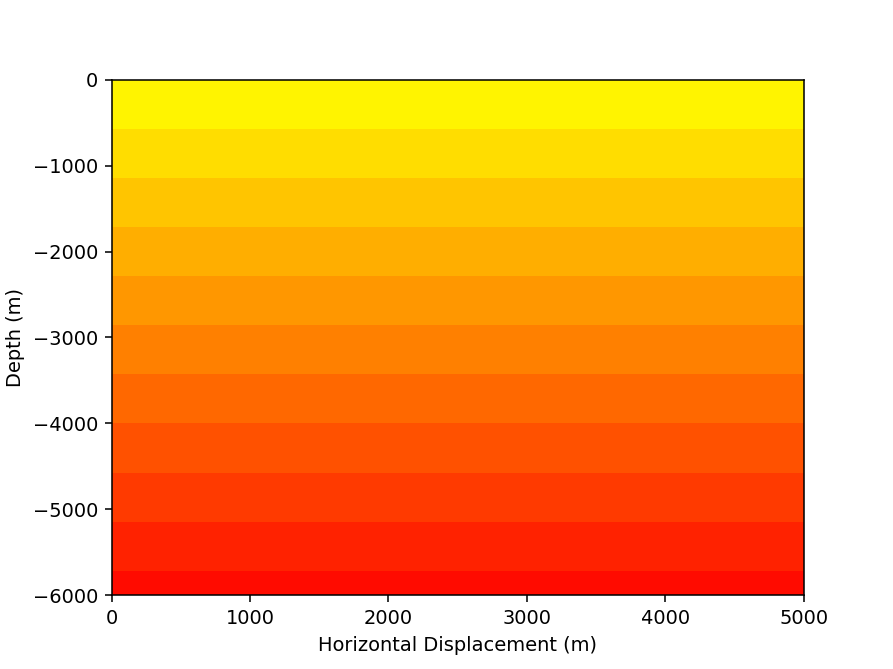

Solution has been plotted  ...


In [17]:
mypde.getSolverOptions().setVerbosityOn()
mypde.setSymmetryOn()
T=mypde.getSolution()

# makes an interactive plotting window
%matplotlib notebook

import matplotlib
import pylab as pl #Plotting package
from cblib import toRegGrid
import os

xi, yi, zi = toRegGrid(T, nx=50, ny=50)
pl.matplotlib.pyplot.autumn()
pl.contourf(xi,yi,zi,10)
pl.xlabel("Horizontal Displacement (m)")
pl.ylabel("Depth (m)")
pl.show()

save_path= os.path.join("data","example04")
mkDir(save_path)
pl.savefig(os.path.join(save_path,"example04.png"))
print("Solution has been plotted  ...")

## 4.4 Example 5: A Heat Refraction Model

**The scripts referenced in this section are: example05a.py and cblib.py**

Our heat refraction model will be a large anticlinal structure that is subject to a constant temperature at the surface and experiencing a steady heat flux at its base. Our aim is to show that the temperature flux across the surface is not linear from bottom to top, but is in fact warped by the structure of the model. The heat flow pattern demonstrates the dependence upon the material properties and the shape of the interface.

The script of Section 4.2 is modified by subdividing the block into two parts. The curve separating the two
blocks is given as a spline, see Figure (4.4). The data points used to define the curve may be imported from a
database of measurements (*e.g.* borehole depth data), but for simplicity it is assumed here that the coordinates are known in an analytic form.

<br>
 <figure>
  <img src="figures/anticlineheatrefraction.png" width="400">
  <figcaption>
    <center>
      Figure 4.4: Example 5a: Heat refraction model with point and line labels.
    </center>
  </figcaption>
 </figure>
<br>

There are two modes available in this example. When `modal=1`, this indicates to the script that the model should be an anticline. Otherwise, when `modal=-1`, the model is a syncline. The modal operator simply changes the orientation of the boundary function so that it is either upwards or downwards curving. A `save_path` has also been defined so that we can easily separate our data from other examples and our scripts. 

It is now possible to start defining our domain and boundaries. 

The curve defining our clinal structure is located approximately in the middle of the domain and has a sinusoidal shape. We define the curve by generating points at discrete intervals; $51$ in this case, and then create a smooth curve through the points using the `Spline()` function.

In [18]:
modal=-1
save_path= os.path.join("data","example05") 
mkDir(save_path)

#Model Parameters
width=5000.0*m   #width of model
depth=-6000.0*m  #depth of model
Ttop=20*K       # top temperature
qin=70*Milli*W/(m*m) # bottom heat influx

sspl=51 #number of discrete points in spline
dsp=width/(sspl-1) #dx of spline steps for width
dep_sp=2500.0*m #avg depth of spline
h_sp=1500.0*m #heigh of spline
orit=-1.0 #orientation of spline 1.0=>up -1.0=>down

# Domain Corners
p0=Point(0.0, 0.0, 0.0)
p1=Point(0.0, depth, 0.0)
p2=Point(width, depth, 0.0)
p3=Point(width, 0.0, 0.0)

# Material Boundary
x=[ Point(i*dsp\
    ,-dep_sp+modal*orit*h_sp*cos(pi*i*dsp/dep_sp+pi))\
     for i in range(0,sspl)\
    ]
mysp = Spline(*tuple(x)) #*tuple() forces x to become a tuple

The start and end points of the spline can be returned to help define the material boundaries.

In [19]:
x1=mysp.getStartPoint()
x2=mysp.getEndPoint()

The top block or material above the clinal/spline boundary is defined in an **anti-clockwise** manner by creating lines and then a closed loop. By meshing the sub-domain we also need to assign it a planar surface. 

In [20]:
# TOP BLOCK
tbl1=Line(p0,x1)
tbl2=mysp
tbl3=Line(x2,p3)
l30=Line(p3, p0)
tblockloop = CurveLoop(tbl1,tbl2,tbl3,l30)
tblock = PlaneSurface(tblockloop)

This process is repeated for every other sub-domain. In this example there is only one other, the bottom block. The process is similar to the top block but with a few differences. The spline points must be reversed by setting the spline as negative.

In [21]:
bbl4=-mysp

This reverse spline option unfortunately does not work for the `getLoopCoords` command, however, the `matplotlib` polygon tool will accept clock-wise oriented points so we can define a new curve.

In [22]:
#clockwise check
#bblockloop=CurveLoop(mysp,Line(x2,p2),Line(p2,p1),Line(p1,x1))
# surface
#bblock = PlaneSurface(bblockloop)

# Create BOTTOM BLOCK
# lines
bbl1=Line(x1,p1)
bbl3=Line(p2,x2)
bbl4=-mysp
l12=Line(p1, p2)
# curve
bblockloop = CurveLoop(bbl1,l12,bbl3,bbl4)
# surface
bblock = PlaneSurface(bblockloop)

The last few steps in creating the domain require that the previously defined domain and sub-domain points are submitted to generate a mesh that can be imported into *escript*. To initialise the mesh it first needs some design parameters. In this case we have 2 dimensions `dim` and a specified number of finite elements that need
to be applied to the domain `element_size`. It then becomes a simple task of adding the sub-domains and flux boundaries to the design. Each element of our model can be given an identifier which makes it easier to define the sub-domain properties in the solution script. This is done using the `PropertySet()` function. The geometry and mesh are then saved so the *escript* domain can be created.

In [23]:
# Create a Design which can make the mesh
d=Design(dim=2, element_size=200)
# Add the sub-domains and flux boundaries.
d.addItems(PropertySet("top",tblock),PropertySet("bottom",bblock),PropertySet("linebottom",l12))
# Create the geometry, mesh and escript domain
d.setScriptFileName(os.path.join(save_path,"example05.geo"))
d.setMeshFileName(os.path.join(save_path,"example05.msh"))
domain=MakeDomain(d,optimizeLabeling=True)

Tag bottom is mapped to id  80
Tag linebottom is mapped to id  81
Tag top is mapped to id  79


The creation of our domain and its mesh is now complete.

With the mesh imported it is now possible to use our tagging property to set up our PDE coefficients. In this case $\kappa$ is set via the `setTaggedValue()` function which takes two arguments, the name of the tagged points and the value to assign to them. 

In [24]:
# set up kappa (thermal conductivity across domain) using tags
kappa=Scalar(0,Function(domain))
kappa.setTaggedValue("top",2.0*W/m/K)
kappa.setTaggedValue("bottom",4.0*W/m/K)

No further changes are required to the PDE solution step, see Figure (4.5) for the result. 

<br>
 <figure>
  <img src="figures/heatrefraction.png" width="400">
  <figcaption>
    <center>
      Figure 4.4: Example 5a: Temperature Distribution in the Heat Refraction Model.
    </center>
  </figcaption>
 </figure>
<br>

PDE has been generated ...
PDE has been solved  ...


<IPython.core.display.Javascript object>


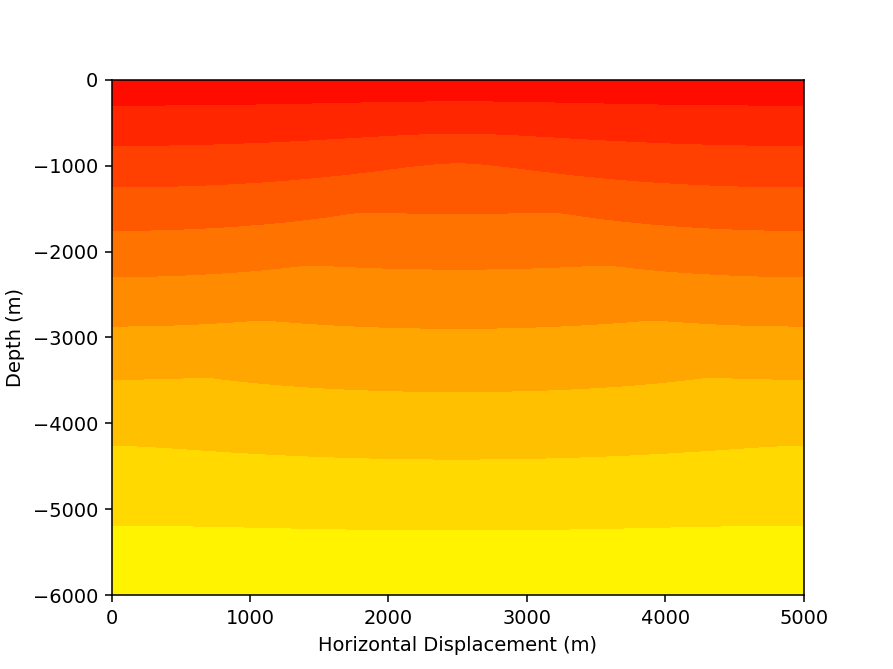

Solution has been plotted  ...


In [25]:
##############################################################SOLVE PDE
mypde=LinearPDE(domain)
mypde.getSolverOptions().setVerbosityOn()
mypde.setSymmetryOn()
mypde.setValue(A=kappa*kronecker(domain))
x=Solution(domain).getX()
mypde.setValue(q=whereZero(x[1]-sup(x[1])),r=Ttop)
qS=Scalar(0,FunctionOnBoundary(domain))
qS.setTaggedValue("linebottom",qin)
mypde.setValue(y=qS)
print("PDE has been generated ...")
###########################################################GET SOLUTION
T=mypde.getSolution()
print("PDE has been solved  ...")

#######################################################################
xi, yi, zi = toRegGrid(T, nx=50, ny=50)
pl.figure(2)
pl.matplotlib.pyplot.autumn()
pl.contourf(xi,yi,zi,10)
pl.xlabel("Horizontal Displacement (m)")
pl.ylabel("Depth (m)")
pl.show()
pl.savefig(os.path.join(save_path,"Tcontour.png"))
print("Solution has been plotted  ...")

## 4.5 Line Profiles of 2D Data

**The scripts referenced in this section are: example05b.py and cblib.py**

We want to investigate the profile of the data of the last example. Of particular interest is the depth profile of the heat flux which is the second component of $-\kappa \nabla T$. The script from the previous section
is extended to show how a vertical profile can be plotted.

The first important piece of information, is that *escript* assumes that $-\kappa \nabla T$ is not smooth and that the point values of this solution are defined at numerical interpolation points. This assumption is reasonable as the flux is the product of the piecewise constant function $\kappa$ and the gradient of the temperature $T$ which has a discontinuity at the rock interface. Before plotting this function we need to smooth the solution using the `Projector()` class:

In [26]:
from esys.escript.pdetools import Projector
proj=Projector(domain)
qu=proj(-kappa*grad(T))

The `proj` object provides a mechanism to distribute values given at the numerical interpolation points to the nodes of the FEM mesh - the heat flux in this example. `qu` has the same function space as the temperature
`T`. The smoothed flux is interpolated to a regular $200\times 200$ grid using the `toRegGrid` function:

In [27]:
xiq,yiq,ziq = toRegGrid(qu[1],200,200)

At return `ziq[j,i]` is the value of vertical heat flux at point (`xiq[i]`,`yiq[j]`). We can easily create deep profiles now by plotting slices `ziq[:,i]` over `yiq`. The following script creates a deep profile at $x_{0}=\frac{width}{2}$:

<IPython.core.display.Javascript object>


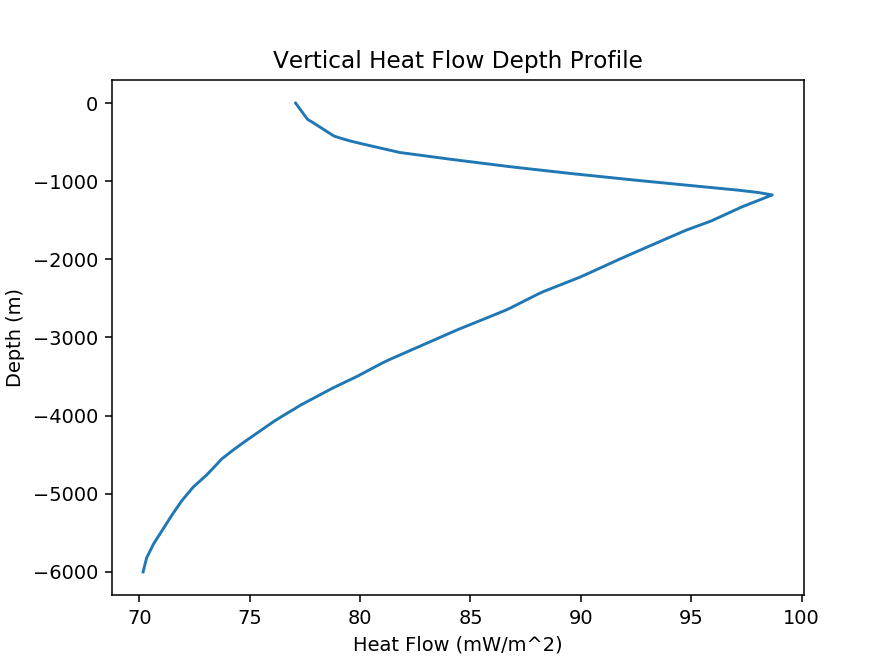

In [28]:
cut=int(len(xiq)/2)
pl.figure(3)
pl.plot(ziq[:,cut]*1000.,yiq)
pl.title("Vertical Heat Flow Depth Profile")
pl.xlabel("Heat Flow (mW/m^2)")
pl.ylabel("Depth (m)")
pl.show()
pl.savefig(os.path.join(save_path,"hf.png"))

This process can be repeated for other variations of the solution, e.g., temperature gradient and thermal conductivity:

<IPython.core.display.Javascript object>


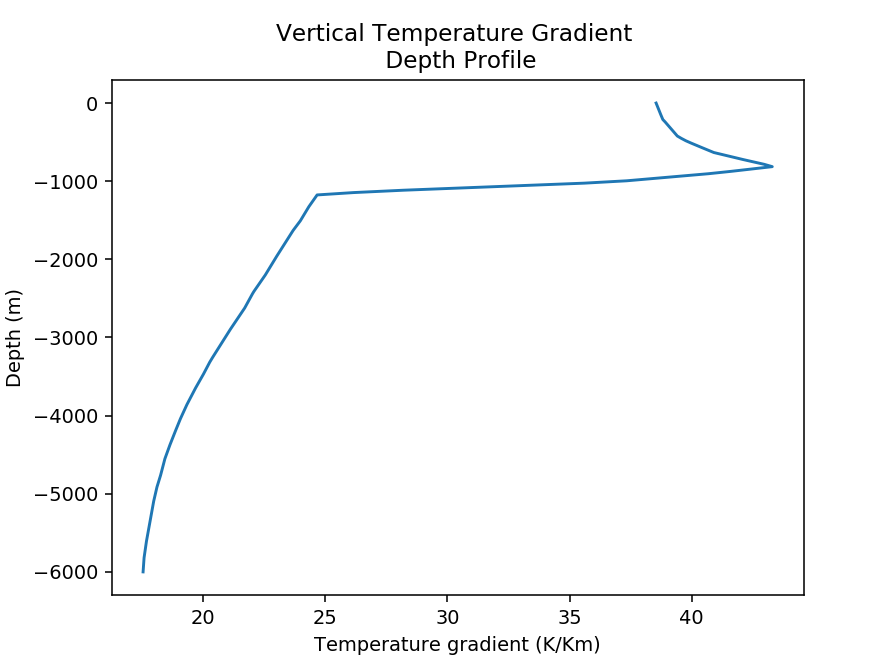

In [29]:
# Temperature Gradient Depth Profile at x[50]
zT=proj(-grad(T))
xt,yt,zt=toRegGrid(zT[1],200,200)
cut=int(len(xt)//2)
pl.figure(4)
pl.plot(zt[:,cut]*1000.,yt)
pl.title("Vertical Temperature Gradient \n Depth Profile")
pl.xlabel("Temperature gradient (K/Km)")
pl.ylabel("Depth (m)")
pl.show()
pl.savefig(os.path.join(save_path,"tgdp.png"))

<IPython.core.display.Javascript object>


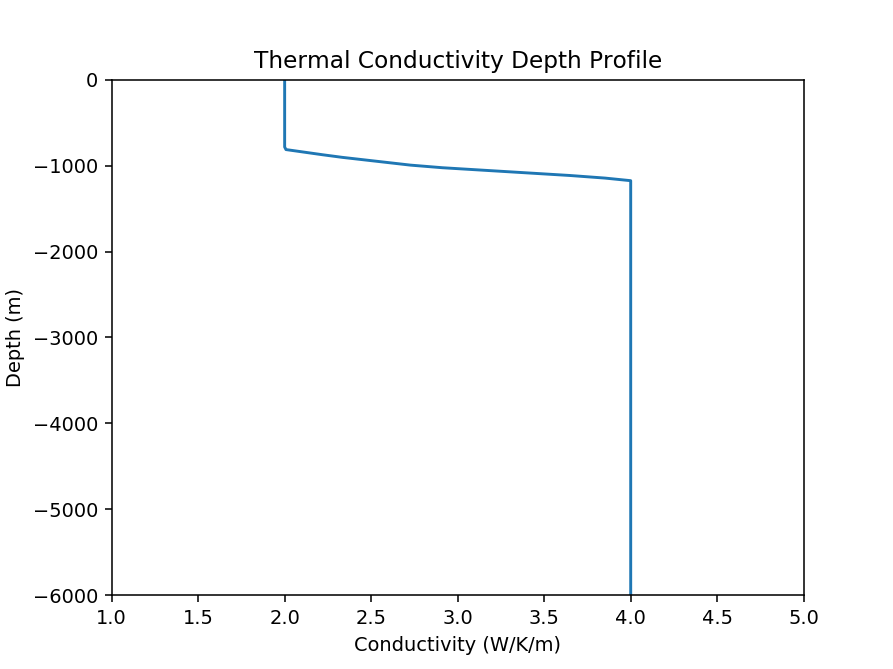

In [30]:
# Thermal Conditions Depth Profile    
xk,yk,zk = toRegGrid(proj(kappa),200,200)
cut=int(len(xk)//2)
pl.figure(5)
pl.plot(zk[:,cut],yk)
pl.title("Thermal Conductivity Depth Profile")
pl.xlabel("Conductivity (W/K/m)")
pl.ylabel("Depth (m)")
pl.axis([1,5,-6000,0])
pl.show()
pl.savefig(os.path.join(save_path,"tcdp.png"))

Compare your results with Figure (4.6).

<br>
 <figure>
  <img src="figures/heatrefractiontgdp.png" width="400">
 </figure>

 <figure>
  <img src="figures/heatrefractiontcdp.png" width="400">
 </figure>

 <figure>
  <img src="figures/heatrefractionhf.png" width="400">
  <figcaption>
    <center>
      Figure 4.6: Example 5b: Depth profiles down centre of model.
    </center>
  </figcaption>
 </figure>
<br>

## 4.6 Arrow Plots in `matplotlib`

**The scripts referenced in this section are: example05c.py and cblib.py**

This section will show how the distribution of the flux $-\kappa \nabla T$ is visualised and plotted over the domain, including: a contour plot of the temperature, a coloured representation of the two sub-domains where colour represents the thermal conductivity in the particular region, and the arrows representing the local direction of the steepest gradient of the flux.

Contours have already been discussed in Section 3.3 and are plotted using: 

<IPython.core.display.Javascript object>


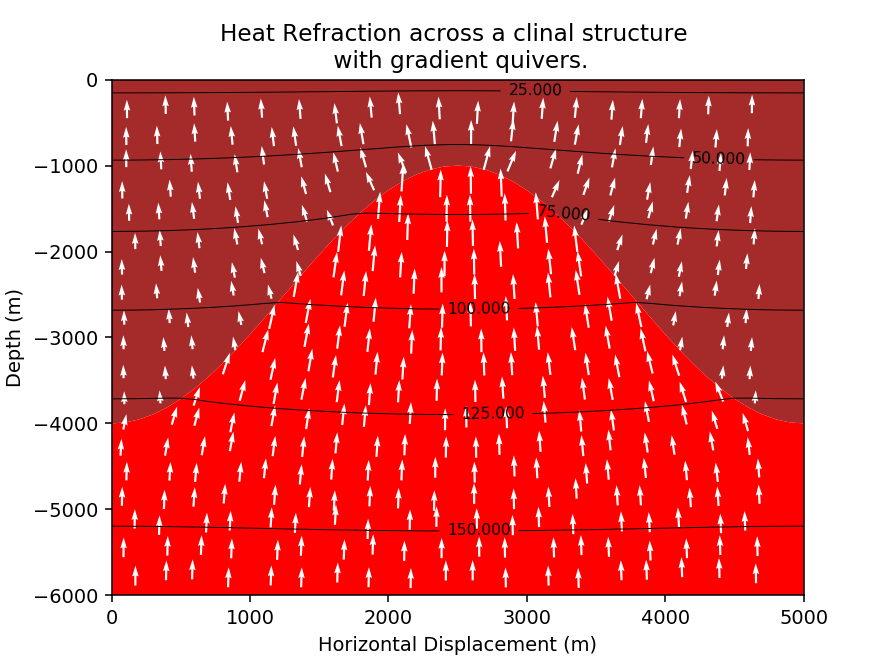

<a list of 6 text.Text objects>

In [31]:
pl.figure(6)
xi, yi, zi = toRegGrid(T, nx=50, ny=50)
CS = pl.contour(xi,yi,zi,5,linewidths=0.5,colors='k')
pl.clabel(CS, inline=1, fontsize=8)

To show sub-domains, we need to go back to `esys.pycad` data to get the points used to describe the boundary of the sub-domains. We have created the `CurveLoop` class object `tblockloop` to define the boundary of the upper sub-domain. We use the `getPolygon()` method of `CurveLoop` to get access to the `Point`s used to define the boundary. The statement

```python
[ p.getCoordinates() for p in tblockloop.getPolygon() ]
```

creates a list of the node coordinates of all the points in question. In order to simplify the selection of the $x$ and $y$ coordinates the list is converted into `numpy` array. To add the area coloured in brown to the plot we use:

In [32]:
import numpy as np
tpg=np.array([p.getCoordinates() for p in tblockloop.getPolygon() ])
pl.fill(tpg[:,0],tpg[:,1],'brown',label='2 W/m/k',zorder=-1000)

The same code is applied to `bblockloop` to create the red area for this sub-domain:

In [33]:
bpg=np.array([p.getCoordinates() for p in bblockloop.getPolygon() ])
pl.fill(bpg[:,0],bpg[:,1],'red',label='4 W/m/k',zorder=-1000)

To plot vectors representing the flux orientation we use the `quiver` function in `pylab`. The function places vectors at locations in the domain. For instance one can plot vectors at the locations of the sample points used by *escript* to represent the flux `-kappa*grad(T)`. As a vector is plotted at each sample point one typically ends up with too many vectors. So one needs to select a subset of points as follows:

First we create a coarse grid of points on a rectangular mesh, e.g. $20 \times 20$ points. Here we choose a grid of points which are located at the centre of a `nx` $\times$ `ny` grid:

In [34]:
nx = 20
ny = 20
dx = width/nx # x spacing
dy = depth/ny # y spacing
grid = [ ] # the grid points
for j in range(0,ny-1):
    for i in range(0,nx-1):
           grid.append([dx/2+dx*i,dy/2+dy*j])

With the `Locator` function *escript* provides a mechanism to identify sample points that are closest to the grid points we have selected and to retrieve the data at these points:

In [35]:
from esys.escript.pdetools import Locator
flux=-kappa*grad(T)
fluxLoc = Locator(flux.getFunctionSpace(),grid)
subflux= fluxLoc(flux) 

`subflux` now contains a list of flux components at certain sample points. To get the list of the sample point coordinates one can use the `getX()` method of the `Locator`:

In [36]:
subfluxloc = fluxLoc.getX()

To simplify the selection of $x$ and $y$ components it is convenient to transform `subflux` and `subfluxloc` to `numpy` arrays `xflux`, `flux`. This function is implemented in the `subsample` function within the `clib.py` file so we can use it in other examples. One can easily use this function to create a vector plot of the flux:

In [37]:
from cblib import subsample
xflux, flux=subsample(-kappa*grad(T), nx=20, ny=20)
pl.quiver(xflux[:,0],xflux[:,1],flux[:,0],flux[:,1], angles='xy',color="white")

Finally, we add a title and labels:

In [38]:
pl.title("Heat Refraction across a clinal structure.")
pl.xlabel("Horizontal Displacement (m)")
pl.ylabel("Depth (m)")
pl.title("Heat Refraction across a clinal structure \n with gradient quivers.")
pl.savefig(os.path.join(save_path,"flux.png"))

Compare your result (Figure 6) to Figure (4.7) below.

<br>
 <figure>
  <img src="figures/heatrefractionflux.png" width="600">
  <figcaption>
    <center>
      Figure 4.7: Example 5c: Heat refraction model with gradient indicated by vectors.
    </center>
  </figcaption>
 </figure>
<br>

## 4.7 Example 6: Fault and Overburden Model

**The scripts referenced in this section are: example06.py and cblib.py**

A slightly more complicated model that contains three blocks is used in this section. Please read through the code blocks below and compare your results with Figure (4.8).

<br>
 <figure>
  <img src="figures/heatrefraction2flux.png" width="600">
  <figcaption>
    <center>
      Figure 4.8: Example 6: Heat refraction model with three blocks and heat flux.
    </center>
  </figcaption>
 </figure>
<br>

ESTABLISHING VARIABLES:

In [39]:
# where to put output files
save_path= os.path.join("data","example06")
mkDir(save_path)

Ttop=20*Celsius # temperature at the top
qin=300.*Milli*W/(m*m) #our heat source temperature is now zero

DOMAIN CONSTRUCTION:

In [40]:
# Points
p0=Point(0.0,        0.0, 0.0)
p1=Point(0.0,    -6000.0, 0.0)
p2=Point(5000.0, -6000.0, 0.0)
p3=Point(5000.0,     0.0, 0.0)

# Lines
l01=Line(p0, p1)
l12=Line(p1, p2)
l23=Line(p2, p3)
l30=Line(p3, p0)

# Generate Material Boundary
p4=Point(0.0,    -2400.0, 0.0)
p5=Point(2000.0, -2400.0, 0.0)
p6=Point(3000.0, -6000.0, 0.0)
p7=Point(5000.0, -2400.0, 0.0)

# Create TOP BLOCK
tbl1=Line(p0,p4)
tbl2=Line(p4,p5)
tbl3=Line(p5,p7)
tbl4=Line(p7,p3)
tblockloop = CurveLoop(tbl1,tbl2,tbl3,tbl4,l30)
tblock = PlaneSurface(tblockloop)

# Create BOTTOM BLOCK LEFT
bbll1=Line(p4,p1)
bbll2=Line(p1,p6)
bbll3=Line(p6,p5)
bbll4=-tbl2
bblockloopl = CurveLoop(bbll1,bbll2,bbll3,bbll4)
bblockl = PlaneSurface(bblockloopl)

# Create BOTTOM BLOCK RIGHT
bbrl1=Line(p6,p2)
bbrl2=Line(p2,p7)
bbrl3=-tbl3
bbrl4=-bbll3
bblockloopr = CurveLoop(bbrl1,bbrl2,bbrl3,bbrl4)
bblockr = PlaneSurface(bblockloopr)

EXPORTING MESH FOR ESCRIPT:

In [41]:
# Create a Design which can make the mesh
d=Design(dim=2, element_size=200)
# Add the subdomains and flux boundaries.
d.addItems(PropertySet("top",tblock),\
           PropertySet("bottomleft",bblockl),\
           PropertySet("bottomright",bblockr),\
           PropertySet("linebottom",bbll2, bbrl1))

# Create the geometry, mesh and Escript domain
d.setScriptFileName(os.path.join(save_path,"example06.geo"))

d.setMeshFileName(os.path.join(save_path,"example06.msh"))
domain=MakeDomain(d)

# set up kappa (thermal conductivity across domain) using tags
kappa=Scalar(0,Function(domain))
kappa.setTaggedValue("top",2.0)
kappa.setTaggedValue("bottomleft",10.0)
kappa.setTaggedValue("bottomright",6.0)

Tag bottomleft is mapped to id  110
Tag bottomright is mapped to id  111
Tag linebottom is mapped to id  112
Tag top is mapped to id  109


SOLVE PDE:

In [42]:
mypde=LinearPDE(domain)
mypde.getSolverOptions().setVerbosityOn()
mypde.setSymmetryOn()
mypde.setValue(A=kappa*kronecker(domain))
x=Solution(domain).getX()
mypde.setValue(q=whereZero(x[1]-sup(x[1])),r=Ttop)
qS=Scalar(0,FunctionOnBoundary(domain))
qS.setTaggedValue("linebottom",qin)
mypde.setValue(y=qS)
T=mypde.getSolution()
print("PDE has been solved ...")

PDE has been solved ...


PLOTTING:

<IPython.core.display.Javascript object>


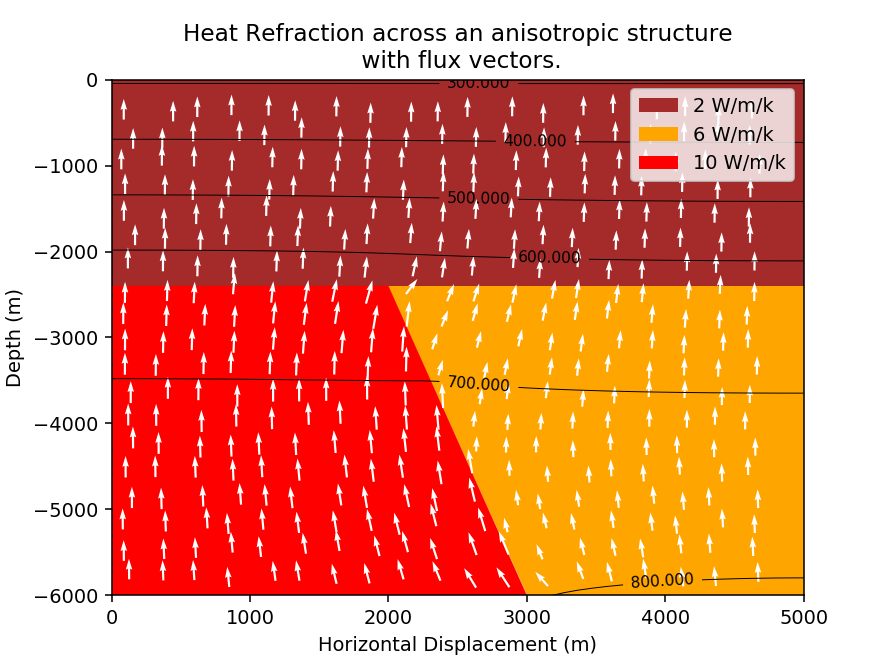

Flux has been plotted  ...


In [43]:
# show temperature:
pl.figure(7)
xi, yi, zi = toRegGrid(T, nx=50, ny=50)
CS = pl.contour(xi,yi,zi,5,linewidths=0.5,colors='k')
pl.clabel(CS, inline=1, fontsize=8)
# show sub domains:
tpg=np.array([p.getCoordinates() for p in tblockloop.getPolygon() ])
pl.fill(tpg[:,0],tpg[:,1],'brown',label='2 W/m/k',zorder=-1000)
bpgr=np.array([p.getCoordinates() for p in bblockloopr.getPolygon() ])
pl.fill(bpgr[:,0],bpgr[:,1],'orange',label='6 W/m/k',zorder=-1000)
bpgl=np.array([p.getCoordinates() for p in bblockloopl.getPolygon() ])
pl.fill(bpgl[:,0],bpgl[:,1],'red',label='10 W/m/k',zorder=-1000)
# show flux:
xflux, flux=subsample(-kappa*grad(T), nx=20, ny=20)
pl.quiver(xflux[:,0],xflux[:,1],flux[:,0],flux[:,1], angles='xy',color="white")
# create plot
pl.title("Heat Refraction across an anisotropic structure\n with flux vectors.")
pl.xlabel("Horizontal Displacement (m)")
pl.ylabel("Depth (m)")
pl.legend()
pl.savefig(os.path.join(save_path,"flux.png"))
print("Flux has been plotted  ...")